# Utils

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 

import sklearn
from sklearn.preprocessing import StandardScaler

from tqdm.contrib.itertools import product

import timeit

from matplotlib import pyplot as plt
import seaborn as sns

from eval import evaluate
from data import load_data
from dimred import fit_UMAP, fit_HUMAP, fit_PMAP

In [2]:
def evaluate_hyperparameters(data, dataset_name, data_subset_name, method_name,
                             hyperparameter_dict, num_repeats, evaluate_hyperparameter_combination, save):
    
    embeds = data[dataset_name][data_subset_name]["signatures"]
    df_meta = data[dataset_name][data_subset_name]["metadata"]

    metric_df = None

    hyperparameter_dict_keys, hyperparameter_dict_values = zip(*hyperparameter_dict.items())
    hyperparameter_combinations = product(*hyperparameter_dict_values) 
    for hyperparameter_combination in hyperparameter_combinations:
        hyperparameter_combination = dict(zip(hyperparameter_dict_keys, hyperparameter_combination))
        name = method_name + "_" + "_".join(str(v) for v in hyperparameter_combination.values())

        metric_dict_over_repeats = None
        for _ in range(num_repeats):

            metric_dict = evaluate_hyperparameter_combination(embeds, df_meta, hyperparameter_combination)
            
            if metric_dict_over_repeats is None:
                metric_dict_over_repeats = metric_dict
            else:
                for k, v in metric_dict.items():
                    for kk, vv in v.items():
                        metric_dict_over_repeats[k][kk] += vv

        metric_dict_aggregated = {}
        for k, v in metric_dict_over_repeats.items():
            metric_dict_aggregated[k] = {}
            for kk, vv in v.items():
                metric_dict_aggregated[k][kk] = {}
                metric_dict_aggregated[k][kk][name+"_mean"] = round(np.mean(vv),4)
                metric_dict_aggregated[k][kk][name+"_std"] = round(np.std(vv),4)
        metric_df_aggregated = pd.DataFrame.from_dict({(i,j): metric_dict_aggregated[i][j] for i in metric_dict_aggregated.keys() for j in metric_dict_aggregated[i].keys()}, orient='index')

        if metric_df is None:
            metric_df = metric_df_aggregated
        else:
            metric_df = pd.concat([metric_df, metric_df_aggregated], axis=1)

    if save:
        metric_df.to_pickle("results/" + dataset_name + "/" + data_subset_name + "_hyperparameters_" + method_name + "__" + '__'.join(str(v) for v in hyperparameter_dict.keys()) + ".pkl")
    
    return metric_df

In [3]:
def bar_plot(df, x, y, hue, xlabel, ylabel, title, save_name, fontsize=12):
    
    plt.rcParams["figure.dpi"] = 150
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    ax = sns.barplot(x=x, y=y, hue=hue, data=df, errorbar=None , capsize=0.1, palette = sns.color_palette("deep"))

    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches[:len(df)]]
    y_coords = [p.get_height() for p in ax.patches[:len(df)]]
    ax.errorbar(x=x_coords, y=y_coords, yerr=df["std"].values, fmt="none", c="k")

    if xlabel is None:
        ax.set(xticklabels=[])
    plt.xlabel(xlabel, fontsize=fontsize+2)
    plt.ylabel(ylabel, fontsize=fontsize+2)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title(title, fontsize=fontsize+4)
    plt.legend(title='Configuration', bbox_to_anchor=(1.00, 1.02), loc='upper left', fontsize=fontsize)

    if save_name:
        plt.savefig(save_name, bbox_inches = 'tight')

    plt.show()

# Evaluate Hyperparameter Configurations

In [4]:
data = load_data("data/L1000FWD/", "data/SigComLINCS/")

## SIG

In [ ]:
dataset_name = "L1000FWD"
data_subset_name = "landmark"
knn_targets = [(20, "MOA"),(20, "Cell"),(2, "Time")]
#dataset_name = "SigComLINCS"
#data_subset_name = "A375"
#knn_targets = [(20, "MOA"),(2, "Time")]

method_name = "SIG"
num_repeats = 1
save = True

hyperparameter_dict = {
    "distance": ["cosine", "euclidean", "canberra"],
    "preprocessing": ["scaled", "raw"],
    "knn_neighbors": [5, 10, 50],
}

def evaluate_hyperparameter_combination(embeds, df_meta, hyperparameter_combination):
    if hyperparameter_combination["preprocessing"] == "scaled":
        embeddings = StandardScaler().fit_transform(embeds)
    elif hyperparameter_combination["preprocessing"] == "raw":
        embeddings = embeds

    t_start = timeit.default_timer()
    metric_dict = evaluate(embeddings, hyperparameter_combination["distance"], df_meta, 
                            knn_n_neighbors = hyperparameter_combination["knn_neighbors"], knn_targets = knn_targets,
                            global_distance_matrix = None) 
    t_end = timeit.default_timer()
    metric_dict["Execution time"] = {"sec": [(t_end-t_start)/60]}

    return metric_dict

metric_df = evaluate_hyperparameters(data, dataset_name, data_subset_name, method_name, hyperparameter_dict, num_repeats, evaluate_hyperparameter_combination, save)

## UMAP

In [ ]:
dataset_name = "L1000FWD"
data_subset_name = "landmark"
knn_targets = [(20, "MOA"),(20, "Cell"),(2, "Time")]
#dataset_name = "SigComLINCS"
#data_subset_name = "A375"
#knn_targets = [(20, "MOA"),(2, "Time")]

method_name = "UMAP_2"
dimension = 2
num_repeats = 5
save = True

hyperparameter_dict = {
    "neighbors": [3, 5, 25, 50, 250],
    "min_distance": [0.001, 0.01, 0.05, 0.1, 0.5],
}

def evaluate_hyperparameter_combination(embeds, df_meta, hyperparameter_combination):
    t_start = timeit.default_timer()
    embeddings = fit_UMAP(embeds, dimension, n_neighbors=hyperparameter_combination["neighbors"], min_dist=hyperparameter_combination["min_distance"], metric="cosine")
    t_end = timeit.default_timer() 

    metric_dict = evaluate(embeddings, "euclidean", df_meta, 
                            knn_n_neighbors = 5, knn_targets = knn_targets,
                            global_distance_matrix = 1 - sklearn.metrics.pairwise.cosine_similarity(embeds))
    metric_dict["Execution time"] = {"sec": [(t_end-t_start)/60]}

    return metric_dict

metric_df = evaluate_hyperparameters(data, dataset_name, data_subset_name, method_name, hyperparameter_dict, num_repeats, evaluate_hyperparameter_combination, save)

## HUMAP

In [ ]:
dataset_name = "L1000FWD"
data_subset_name = "landmark"
knn_targets = [(20, "MOA"),(20, "Cell"),(2, "Time")]
#dataset_name = "SigComLINCS"
#data_subset_name = "A375"
#knn_targets = [(20, "MOA"),(2, "Time")]

method_name = "HUMAP_2"
dimension = 2
num_repeats = 5
save = True

hyperparameter_dict = {
    "neighbors": [3, 5, 25, 50, 250],
    "min_distance": [0.001, 0.01, 0.05, 0.1, 0.5],
}

def evaluate_hyperparameter_combination(embeds, df_meta, hyperparameter_combination):
    t_start = timeit.default_timer()
    embeddings = fit_HUMAP(embeds, dimension, n_neighbors=hyperparameter_combination["neighbors"], min_dist=hyperparameter_combination["min_distance"], metric="cosine")
    t_end = timeit.default_timer() 

    metric_dict = evaluate(embeddings, "poincaré", df_meta, 
                            knn_n_neighbors = 5, knn_targets = knn_targets,
                            global_distance_matrix = 1 - sklearn.metrics.pairwise.cosine_similarity(embeds))
    metric_dict["Execution time"] = {"sec": [(t_end-t_start)/60]}

    return metric_dict

metric_df = evaluate_hyperparameters(data, dataset_name, data_subset_name, method_name, hyperparameter_dict, num_repeats, evaluate_hyperparameter_combination, save)

## PMAP

In [ ]:
dataset_name = "L1000FWD"
data_subset_name = "landmark"
knn_targets = [(20, "MOA"),(20, "Cell"),(2, "Time")]
#dataset_name = "SigComLINCS"
#data_subset_name = "A375"
#knn_targets = [(20, "MOA"),(2, "Time")]

method_name = "PMAP_2"
dimension = 2
num_repeats = 5
save = True

hyperparameter_dict = {
    "neighbors": [3, 5, 25, 50, 250],
    "learning_rate": [0.01, 0.1, 1],
}

def evaluate_hyperparameter_combination(embeds, df_meta, hyperparameter_combination):
    t_start = timeit.default_timer()
    embeddings = fit_PMAP(embeds, dimension, n_neighbors=hyperparameter_combination["neighbors"], learning_rate=hyperparameter_combination["learning_rate"], metric="cosine")
    t_end = timeit.default_timer() 

    metric_dict = evaluate(embeddings, "poincaré", df_meta, 
                            knn_n_neighbors = 5, knn_targets = knn_targets,
                            global_distance_matrix = 1 - sklearn.metrics.pairwise.cosine_similarity(embeds))
    metric_dict["Execution time"] = {"sec": [(t_end-t_start)/60]}

    return metric_dict

metric_df = evaluate_hyperparameters(data, dataset_name, data_subset_name, method_name, hyperparameter_dict, num_repeats, evaluate_hyperparameter_combination, save)

# Visualize Hyperparameter Configurations

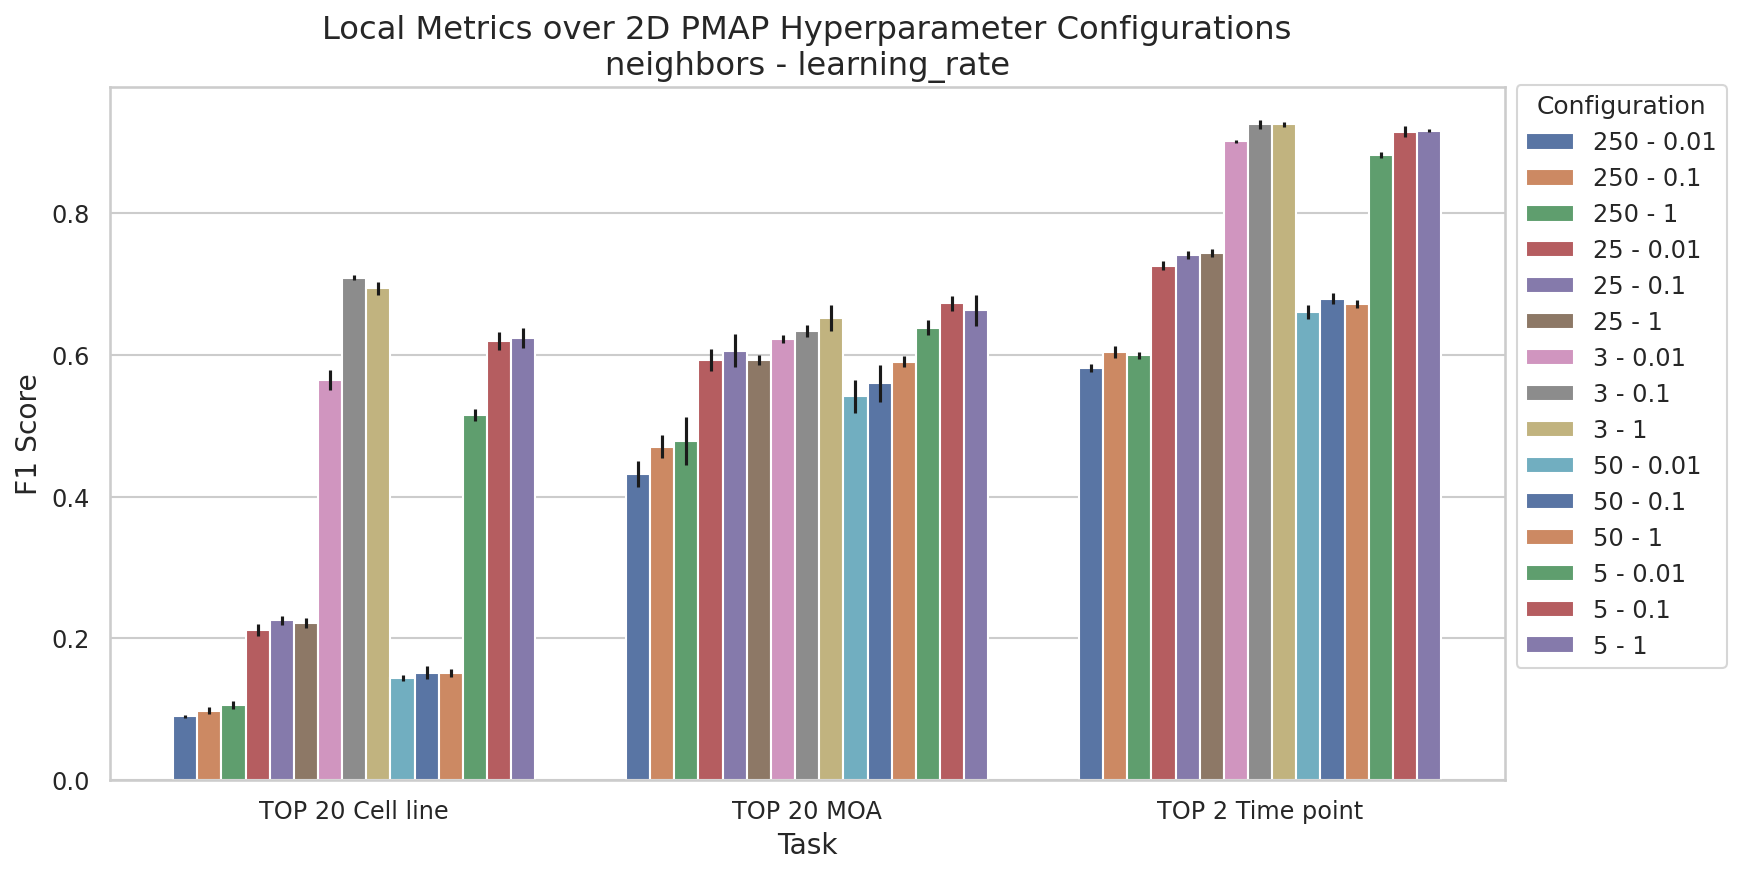

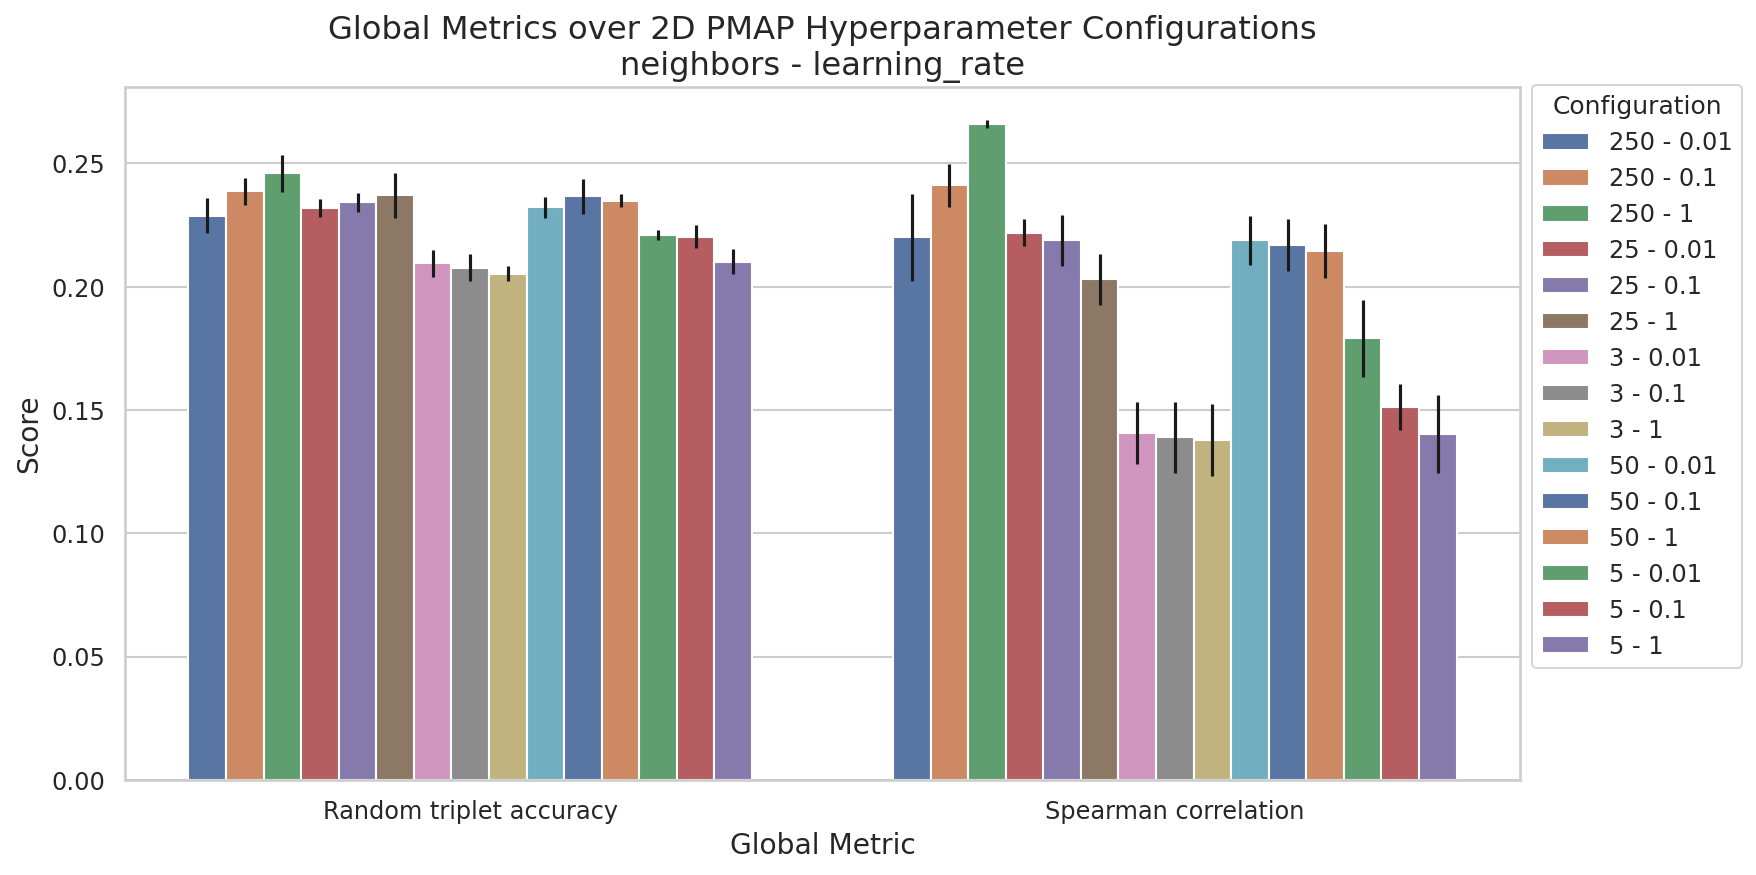

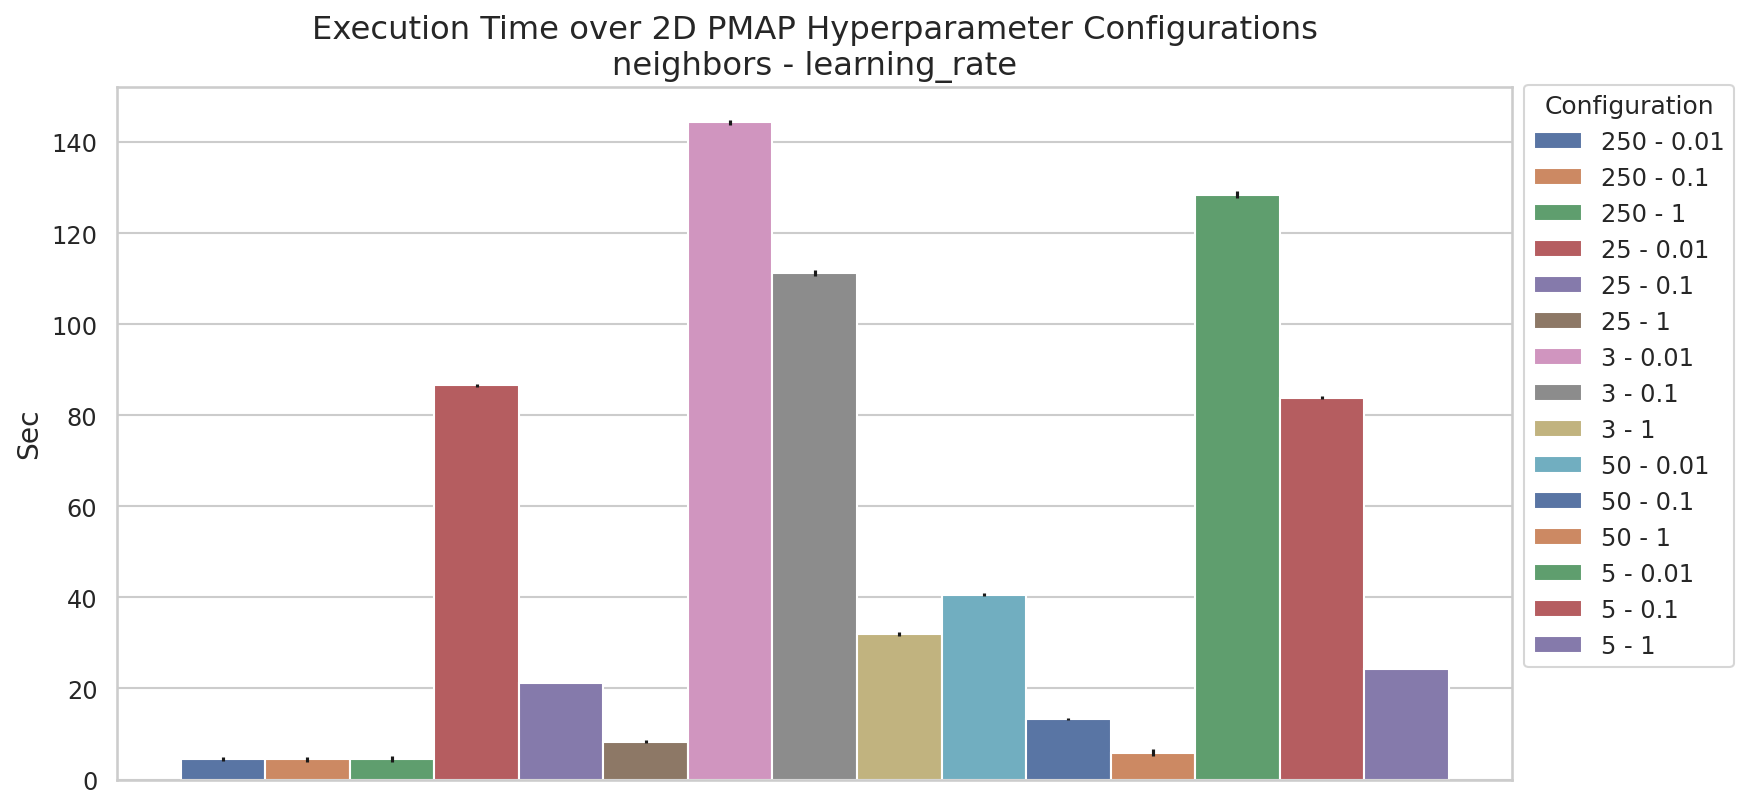

In [5]:
dataset_name = "L1000FWD"
data_subset_name = "landmark"
#dataset_name = "SigComLINCS"
#data_subset_name = "A375"

#method_name = "SIG"
#plot_method_name = "SIG"
#hyperparameters = ["distance", "preprocessing", "knn_neighbors"]

method_name = "PMAP_2"
plot_method_name = "2D PMAP"
#hyperparameters = ["neighbors"]
hyperparameters = ["neighbors", "learning_rate"]
#hyperparameters = ["distance", "neighbors", "learning_rate"]
#hyperparameters = ["neighbors", "knn_neighbors"]
#hyperparameters = ["neighbors", "sigma", "gamma"]

#method_name = "UMAP_2"
#plot_method_name = "2D UMAP"
#method_name = "HUMAP_2"
#plot_method_name = "2D HUMAP"
#hyperparameters = ["neighbors", "min_distance"]
#hyperparameters = ["distance", "neighbors", "min_distance"]
#hyperparameters = ["neighbors", "knn_neighbors"]

save_name = dataset_name + "_" + data_subset_name + "_" + method_name + "__" + '__'.join(h for h in hyperparameters)

metric_df = pd.read_pickle("results/" + dataset_name + "/" + data_subset_name + "_hyperparameters_" + method_name + "__" + '__'.join(h for h in hyperparameters) + ".pkl")

df_plot = metric_df.transpose()
df_plot["type"] = np.array([cid[-1] for cid in np.char.split(df_plot.index.values.astype(str), sep ='_')])
df_plot["model"] = np.array(["_".join(cid[:-1]) for cid in np.char.split(df_plot.index.values.astype(str), sep ='_')])
df_plot = df_plot.reset_index().drop('index', axis = 1)
df_plot = df_plot.pivot(index=['model'], columns='type').stack(level=0).stack(level=0).reset_index()
df_plot = df_plot.rename(columns={"level_1": "task", "level_2": "metric"})

df_plot.replace("TOP_20_Cell", "TOP 20 Cell line", inplace=True)
df_plot.replace("TOP_20_MOA", "TOP 20 MOA", inplace=True)
df_plot.replace("TOP_2_Time", "TOP 2 Time point", inplace=True)
df_plot['model'] = df_plot["model"].apply(lambda x : x[len(method_name)+1:])
df_plot['method'] = method_name
df_plot[hyperparameters] = df_plot['model'].str.split('_', expand=True)
df_plot['model'] = df_plot["model"].apply(lambda x : " - ".join(x.split('_')))

df_plot = df_plot[df_plot["metric"] != "Spearman p_value"]

bar_plot(df_plot[df_plot.metric == 'f1'], x='task', y='mean', hue='model', xlabel = "Task", ylabel = "F1 Score", fontsize=11.5,
          title = "Local Metrics over " + plot_method_name + " Hyperparameter Configurations\n" + " - ".join(h for h in hyperparameters),
          save_name = save_name + "__local.png")

bar_plot(df_plot[df_plot.task == 'global'], x='metric', y='mean', hue='model', xlabel = "Global Metric", ylabel = "Score", fontsize=11.5,
          title = "Global Metrics over " + plot_method_name + " Hyperparameter Configurations\n" + " - ".join(h for h in hyperparameters),
          save_name = save_name + "__global.png")

bar_plot(df_plot[df_plot.task == 'Execution time'], x='metric', y='mean', hue='model', xlabel = None, ylabel = "Sec", fontsize=11.5,
          title = "Execution Time over " + plot_method_name + " Hyperparameter Configurations\n" + " - ".join(h for h in hyperparameters),
          save_name = save_name + "__time.png")